#EE551000 System Theory 
#HW5: Solving cartpole using RL 
 Due: Jan 13, 2020 23:59 

In [3]:
import numpy as np
import keras.backend as K
import keras.losses
import keras.layers as layers
from keras.models import Model
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from collections import defaultdict
import matplotlib.pyplot as plt
from copy import deepcopy
import pickle
from tensorflow.python.tools import module_util as _module_util
import gym

Using TensorFlow backend.


# Get environment

In [0]:
env = gym.make('CartPole-v1')

# Tabular Q-Learning

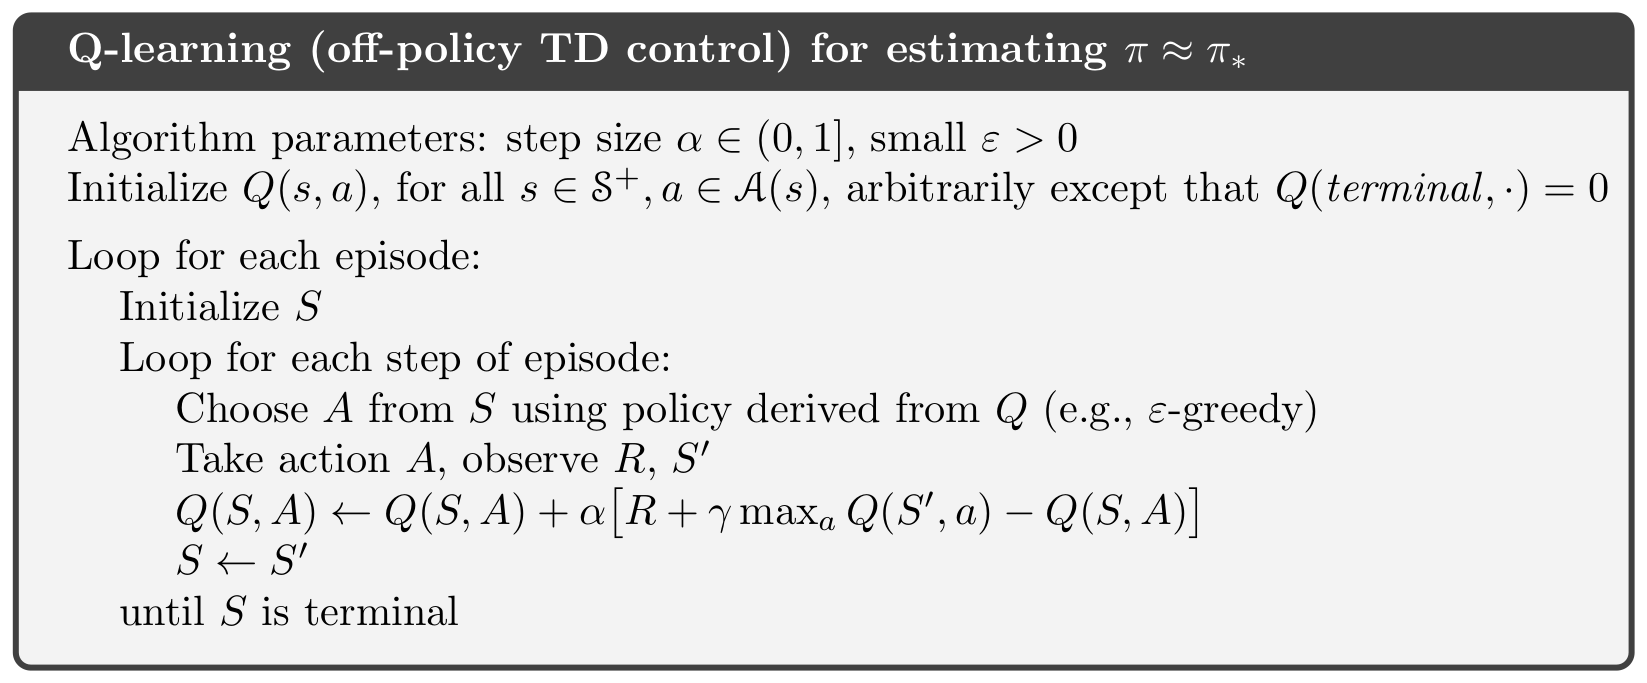

In [0]:
class Tabular_Q_learning():
	def __init__(self, env):
		self.env = env
		self.alpha = 0.1
		self.gamma = 1
		self.epsilon = 0.5
		self.decay = 0.99
		self.epsilon_min = 0.0


		self.cart_position = np.linspace(-2.4, 2.4, num=6)[1:-1]
		self.cart_velocity = np.linspace(-3, 3, num=4)[1:-1]
		self.pole_angle = np.linspace(-0.21, 0.21, num=8)[1:-1]
		self.pole_velocity = np.linspace(-2.0, 2.0, num=6)[1:-1]
		self.Q = defaultdict(lambda: np.zeros(env.action_space.n))

	def continuous_to_discrete(self, state):
		cart_position = np.digitize([state[0]], self.cart_position)[0]
		cart_velocity = np.digitize([state[1]], self.cart_velocity)[0]
		pole_angle = np.digitize([state[2]], self.pole_angle)[0]
		pole_velocity = np.digitize([state[3]], self.pole_velocity)[0]
		return (cart_position, cart_velocity, pole_angle, pole_velocity)


	def update_Q(self, state_c, action, reward, next_state_c, done):
		state = self.continuous_to_discrete(state_c)
		next_state = self.continuous_to_discrete(next_state_c)

		self.Q[state][action] += self.alpha * (reward + self.gamma * max(self.Q[next_state]) - self.Q[state][action])


	def act(self, state_c):
		state = self.continuous_to_discrete(state_c)

		if np.random.uniform(0, 1) < self.epsilon:
			action = self.env.action_space.sample()
		else:
			action = np.argmax(self.Q[state])
		return action



Episode: 0/1000 | Score: 8.00
Episode: 50/1000 | Score: 61.00
Episode: 100/1000 | Score: 121.00
Episode: 150/1000 | Score: 191.00
Episode: 200/1000 | Score: 179.00
Episode: 250/1000 | Score: 217.00
Episode: 300/1000 | Score: 500.00
Episode: 350/1000 | Score: 500.00
Episode: 400/1000 | Score: 500.00
Episode: 450/1000 | Score: 500.00
Episode: 500/1000 | Score: 500.00
Episode: 550/1000 | Score: 500.00
Episode: 600/1000 | Score: 500.00
Episode: 650/1000 | Score: 500.00
Episode: 700/1000 | Score: 500.00
Episode: 750/1000 | Score: 500.00
Episode: 800/1000 | Score: 500.00
Episode: 850/1000 | Score: 500.00
Episode: 900/1000 | Score: 500.00
Episode: 950/1000 | Score: 500.00
CPU times: user 52.6 s, sys: 105 ms, total: 52.7 s
Wall time: 52.6 s


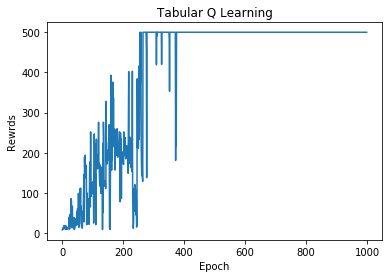

In [21]:
%%time
episodes = 1000
reward_hist = np.zeros((episodes))
agent = Tabular_Q_learning(env)	

for episode in range(episodes):

 state = env.reset()
 agent.epsilon *= agent.decay
 for step in range(500):
  action = agent.act(state)
  next_state, reward, done, _ = env.step(action) 
  if done and step < env._max_episode_steps-1:
    reward = -10000
  agent.update_Q(state, action, reward, next_state, done)
  state = next_state

  if done:
   reward_hist[episode] = step+1
   if episode % 50 == 0:
        print("Episode: {}/{} | Score: {:0.2f}".format(episode, episodes, step+1))
   break
env.close()
fig1 = plt.figure(1)
plt.clf()
plt.plot(reward_hist)
plt.xlabel('Epoch')
plt.ylabel('Rewrds')
plt.title('Tabular Q Learning')


# Policy Gradient Methods


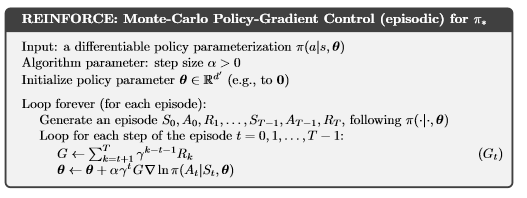

In [0]:
class Policy_gradient():

	def __init__(self, env):
		self.env = env
		self.n_actions = env.action_space.n
		self.n_hidden = 250
		self.gamma = 0.99
		self.dimen = len(env.reset())
		self.lr = 0.01
		self.Build()
		self.states = np.empty(0).reshape(0,self.dimen)
		self.actions = np.empty(0).reshape(0,1)
		self.rewards = np.empty(0).reshape(0,1)
		self.discounted_rewards = np.empty(0).reshape(0,1)


	def Build(self):
	    x = layers.Input(shape=self.env.reset().shape, name="x")
	    adv = layers.Input(shape=[1], name="advantages")
	    h1 = layers.Dense(self.n_hidden, 
	                     activation="relu", 
	                     kernel_initializer='ones',
	                     use_bias=False,
	                     )(x)

	    out = layers.Dense(self.env.action_space.n, 
	                       activation="softmax", 
	                       kernel_initializer='ones',
	                       use_bias=False)(h1)

	    def _loss(y_true, y_pred):
	        log_lik = -y_true * K.log(y_pred + 1e-15)
	        return K.mean(log_lik * adv, keepdims=True)

	    self.model_train = Model(inputs=[x, adv], outputs=out)
	    self.model_train.compile(loss=_loss, optimizer=Adam(self.lr));self.model_train.summary()
	    self.model_predict = Model(inputs=[x], outputs=out)


	def discount_rewards(self, rewards):
	    prev = 0
	    ret = []
	    for reward in rewards:
	        curr = reward + self.gamma * prev
	        ret.append(curr)
	        prev = curr
	    return np.array(list(reversed(ret)))


	def act(self, observation):
	    state = np.reshape(observation, [1, self.dimen])
	    
	    predict = self.model_predict.predict([state])[0]
	    action = np.random.choice(range(self.n_actions),p=predict)
	    self.states = np.vstack([self.states, state])
	    self.actions = np.vstack([self.actions, action])

	    return action


	def train(self, states, actions, discounted_rewards):
	    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / discounted_rewards.std()
	    discounted_rewards = discounted_rewards.squeeze()
	    actions = actions.squeeze().astype(int)
	   
	    actions_train = np.zeros([len(actions), self.n_actions])
	    actions_train[np.arange(len(actions)), actions] = 1
	    
	    loss = self.model_train.train_on_batch([states, discounted_rewards], actions_train)

	    states = np.empty(0).reshape(0,self.dimen)
	    actions = np.empty(0).reshape(0,1)
	    discounted_rewards = np.empty(0).reshape(0,1)
	    return loss


	def test(self, num_tests):
	    scores = []    
	    for num_test in range(num_tests):
	        observation = self.env.reset()
	        reward_sum = 0
	        while True:
	            state = np.reshape(observation, [1, self.dimen])
	            predict = self.model_predict.predict([state])[0]
	            action = np.argmax(predict)
	            observation, reward, done, _ = self.env.step(action)
	            reward_sum += reward
	            if done:
	                break
	        scores.append(reward_sum)
	    self.env.close()
	    return np.mean(scores)


# Train agent using Policy Gradient

batch_size: 1
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               (None, 4)                 0         
_________________________________________________________________
dense_24 (Dense)             (None, 250)               1000      
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 500       
Total params: 1,500
Trainable params: 1,500
Non-trainable params: 0
_________________________________________________________________
Episode: 0/1000 | Score: 151.00
Episode: 50/1000 | Score: 165.00
Episode: 100/1000 | Score: 121.00
Episode: 150/1000 | Score: 252.00
Episode: 200/1000 | Score: 243.00
Episode: 250/1000 | Score: 391.00
Episode: 300/1000 | Score: 500.00
Episode: 350/1000 | Score: 500.00
Episode: 400/1000 | Score: 416.00
Episode: 450/1000 | Score: 500.00
Episode: 500/1000 | Score: 500.00
E

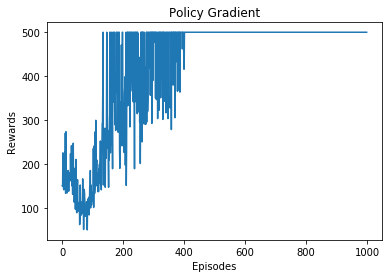

In [31]:
%%time
episodes = 1000
batch_size = 1
print('batch_size:',batch_size)
episode = 0
losses = []
reward_hist = []
test_score = []
agent = Policy_gradient(env)
while episode < episodes:
    observation = agent.env.reset()
    for step in range(env._max_episode_steps):
     action = agent.act(observation)
     observation, reward, done, _ = agent.env.step(action)
     if done and step < env._max_episode_steps-1:
         reward = -10
     agent.rewards = np.vstack([agent.rewards, reward])

     if done:
            reward_hist.append(step)
            discounted_rewards_episode = agent.discount_rewards(agent.rewards)       
            agent.discounted_rewards = np.vstack([agent.discounted_rewards, discounted_rewards_episode])
            agent.rewards = np.empty(0).reshape(0,1)

            if (episode + 1) % batch_size == 0:
             loss = agent.train(agent.states, agent.actions, agent.discounted_rewards)
             losses.append(loss)
		        
            if episode % 1 == 0:
             score = agent.test(1)
             test_score.append(score)
             if episode % 50 == 0:
              print("Episode: {}/{} | Score: {:0.2f}".format(episode, episodes, test_score[-1]))
        
            episode += 1
            break

fig2 = plt.figure(2)
plt.clf()
plt.plot(test_score)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Policy Gradient')

# Actor Critic Methods

In [0]:
class Actor_critic():
    def __init__(self, env):
        self.env = env
        self.gamma = 0.99
        self.actor_lr = 0.001
        self.critic_lr = 0.01 # we want the critic to learn faster than the actor
        self.build_actor()
        self.build_critic()


    def build_actor(self):
        inputs = layers.Input(shape=(4,)) # 
        h1 = layers.Dense(33, activation='relu', kernel_initializer='ones')(inputs)
        d1 = layers.Dropout(0.6, input_shape=(33,))(h1)
        out = layers.Dense(1, activation='sigmoid', kernel_initializer='ones')(d1)
        self.actor = Model(inputs=inputs, outputs=out)

        def _actor_loss(y_true, y_pred):
            action_pred = y_pred
            action_true, td_error = y_true[:, 0], y_true[:, 1]
            action_true = K.reshape(action_true, (-1, 1))
            loss = K.binary_crossentropy(action_true, action_pred)
            return loss * K.flatten(td_error)

        self.actor.compile(loss=_actor_loss, optimizer=Adam(lr=self.actor_lr));self.actor.summary()

    def build_critic(self):
        inputs = layers.Input(shape=(4,))
        h1 = layers.Dense(33, activation='relu')(inputs)
        h2 = layers.Dense(33, activation='relu')(h1)
        out = layers.Dense(1, activation='linear')(h2)
        self.critic = Model(inputs=inputs, outputs=out)
        self.critic.compile(loss='mse', optimizer=Adam(lr=self.critic_lr))


    def discount_reward(self, next_states, reward, done):
        q = self.critic.predict(next_states)[0][0]
        target = reward
        if not done:
            target = reward + self.gamma * q
        
        return target


    def act(self, state):
        prob = self.actor.predict(state)[0][0]
        action = np.random.choice(np.array(range(2)), p=[1 - prob, prob])
        return action


    def train(self, state, action, reward, state_next, done):
        target = self.discount_reward(state_next, reward, done)
        y = np.array([target])

        td_error = target - self.critic.predict(state)[0][0]
        loss1 = self.critic.train_on_batch(state, y)

        y = np.array([[action, td_error]])
        loss2 = self.actor.train_on_batch(state, y)
        return loss1, loss2

# Train agent using Actor Critic

In [0]:
%%time
episodes = 1000
agent = Actor_critic(env)
reward_hist = []
for episode in range(episodes):
        observation = agent.env.reset()

        for step in range(env._max_episode_steps):
            state = observation.reshape(-1, 4)
            action = agent.act(state)

            observation_next, reward, done, _ = agent.env.step(action)
            state_next = observation_next.reshape(-1, 4)
            if done and step < env._max_episode_steps-1:
                reward = -1e-5
            loss1, loss2 = agent.train(state, action, reward, state_next, done)

            observation = state_next[0]

            if done:
                reward_hist.append(step+1)
                if episode % 50 == 0:
                    print('Episode: {}/{} | Score: {}'.format(episode, episodes, step+1))
                break

plt.clf()
plt.plot(reward_hist)
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Actor-critic')

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_26 (Dense)             (None, 33)                165       
_________________________________________________________________
dropout_4 (Dropout)          (None, 33)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 34        
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________
Episode: 0/1000 | Score: 13
Episode: 50/1000 | Score: 21
Episode: 100/1000 | Score: 36
Episode: 150/1000 | Score: 30
Episode: 200/1000 | Score: 96
Episode: 250/1000 | Score: 18
Episode: 300/1000 | Score: 74
Episode: 350/1000 | Score: 145
Episode: 400/1000 | 